<a href="https://colab.research.google.com/github/aholloman79/A-Primer-on-Scientific-Programming-with-Python/blob/master/Exploring_Generalized_Additive_Models_(GAMs)_and_Local_Regression_Techniques_for_Non_Linear_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

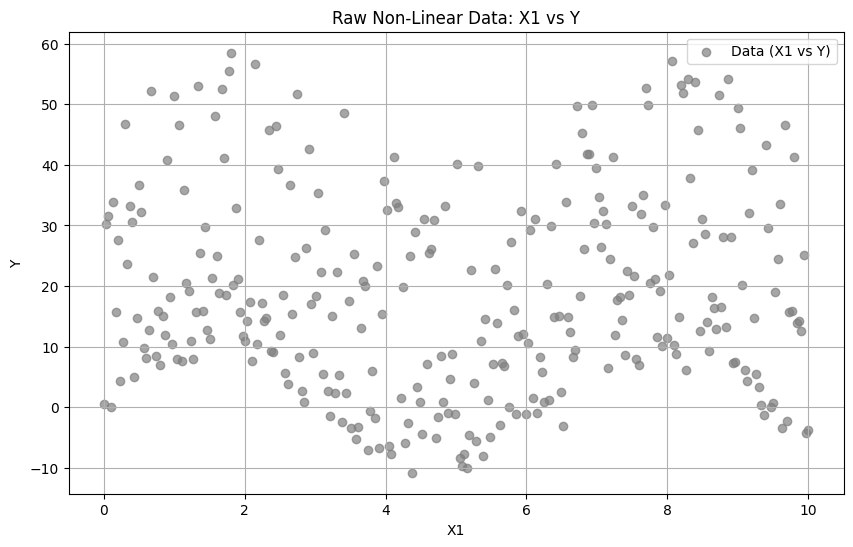


--- LOESS Smoothing Applied on X1 ---


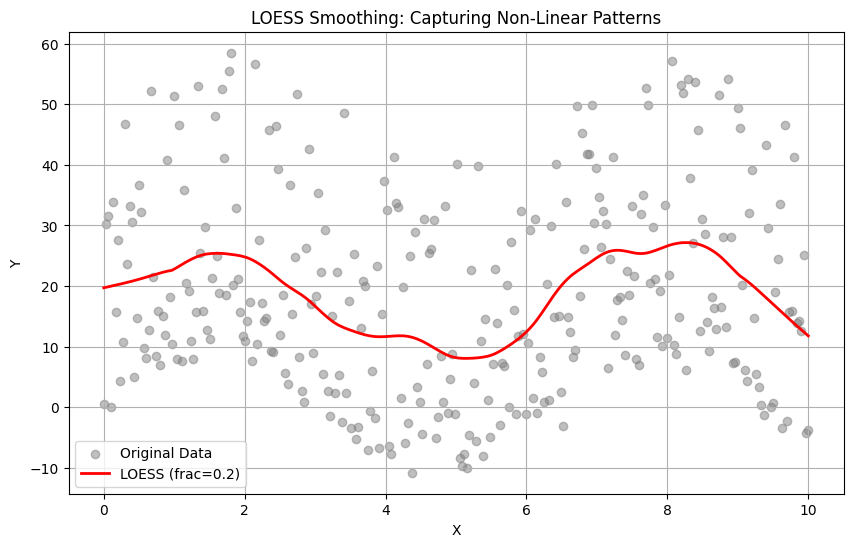


Test Set Mean Squared Error (MSE): 4.4876


ValueError: The feature names should match those that were passed during fit.
Feature names must be in the same order as they were in fit.


In [2]:
# Step 1: Import Libraries
# I started with essential libraries to handle data, implement smoothing techniques, and visualize the results.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from statsmodels.nonparametric.smoothers_lowess import lowess  # For LOESS smoothing
from patsy import dmatrix  # For splines in GAM-like modeling
from sklearn.metrics import mean_squared_error

# Step 2: Simulating Non-Linear Data
# I simulated a dataset with non-linear relationships, similar to what I encounter in biomedical or financial research.

np.random.seed(123)
n_samples = 300  # Number of observations
X1 = np.linspace(0, 10, n_samples)
Y = 10 * np.sin(X1) + np.random.normal(scale=2, size=n_samples)  # Sinusoidal trend with noise

# Adding another non-linear predictor (quadratic)
X2 = np.random.uniform(0, 10, n_samples)
Y += 0.5 * X2**2

# Creating a DataFrame for ease of handling
data = pd.DataFrame({'X1': X1, 'X2': X2, 'Y': Y})

# Visualizing the raw data to confirm the non-linear trends
plt.figure(figsize=(10, 6))
plt.scatter(data['X1'], data['Y'], color='gray', alpha=0.7, label="Data (X1 vs Y)")
plt.xlabel("X1")
plt.ylabel("Y")
plt.title("Raw Non-Linear Data: X1 vs Y")
plt.legend()
plt.grid(True)
plt.show()

# Step 3: LOESS (Local Regression)
# I implemented LOESS smoothing to explore localized relationships.

def loess_fit(X, Y, frac=0.2):
    """
    Fits LOESS smoothing and visualizes the smoothed curve.
    Args:
        X: Predictor variable
        Y: Response variable
        frac: Smoothing span (proportion of data used for local fitting)
    """
    sorted_indices = np.argsort(X)  # Sorting X for smoother curve
    X_sorted = X[sorted_indices]
    Y_sorted = Y[sorted_indices]

    # Applying LOESS smoothing
    loess_results = lowess(Y_sorted, X_sorted, frac=frac, it=0)

    # Visualizing the results
    plt.figure(figsize=(10, 6))
    plt.scatter(X, Y, color='gray', alpha=0.5, label="Original Data")
    plt.plot(loess_results[:, 0], loess_results[:, 1], color='red', linewidth=2, label=f"LOESS (frac={frac})")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("LOESS Smoothing: Capturing Non-Linear Patterns")
    plt.legend()
    plt.grid(True)
    plt.show()

print("\n--- LOESS Smoothing Applied on X1 ---")
loess_fit(data['X1'].values, data['Y'].values, frac=0.2)

# Step 4: Generalized Additive Model (GAM) Using Natural Splines
# Here, I used natural splines for non-linear regression, which mimics a GAM-like behavior.

# Step 4.1: Creating B-Spline Basis Functions for X1 and X2
# I used `dmatrix` to generate spline basis functions for X1 and X2.
X_spline = dmatrix("bs(X1, df=6, degree=3, include_intercept=False) + bs(X2, df=6, degree=3, include_intercept=False)",
                   {"X1": data['X1'], "X2": data['X2']}, return_type='dataframe')

# Step 4.2: Fitting a Linear Model Using the Spline Features
# This approach lets me capture non-linear trends using splines as transformed predictors.
X_train, X_test, Y_train, Y_test = train_test_split(X_spline, data['Y'], test_size=0.2, random_state=42)

# Linear regression on the spline-transformed predictors
model = LinearRegression()
model.fit(X_train, Y_train)

# Step 4.3: Predicting and Visualizing Results
# Predictions on test data
Y_pred = model.predict(X_test)

# Model evaluation using MSE
mse = mean_squared_error(Y_test, Y_pred)
print(f"\nTest Set Mean Squared Error (MSE): {mse:.4f}")

# Visualizing the smooth function for X1 and X2
# I generated partial dependence plots for each predictor.
X1_grid = np.linspace(data['X1'].min(), data['X1'].max(), 100)
X2_grid = np.linspace(data['X2'].min(), data['X2'].max(), 100)

# Generating predictions for X1 (holding X2 constant)
X1_spline = dmatrix("bs(X1, df=6, degree=3, include_intercept=False)", {"X1": X1_grid}, return_type='dataframe')
X2_mean = np.tile(np.mean(data['X2']), len(X1_grid))  # Hold X2 at mean
X_combined = pd.concat([X1_spline, dmatrix("bs(X2, df=6, degree=3, include_intercept=False)",
                                          {"X2": X2_mean}, return_type='dataframe')], axis=1)

Y1_smooth = model.predict(X_combined)

# Plotting the smooth function for X1
plt.figure(figsize=(10, 6))
plt.plot(X1_grid, Y1_smooth, color='blue', linewidth=2, label="Smooth Function for X1")
plt.scatter(data['X1'], data['Y'], color='gray', alpha=0.5, label="Original Data")
plt.xlabel("X1")
plt.ylabel("Y")
plt.title("Generalized Additive Model: Smooth Function for X1")
plt.legend()
plt.grid(True)
plt.show()


# ----------------------------------------------------------------------------------
# Understanding the "ValueError: The feature names should match those that were passed during fit."
# ----------------------------------------------------------------------------------
# During the process of predicting using the GAM-like model, I ran into a frustrating error:
# "ValueError: The feature names should match those that were passed during fit. Feature names must
# be in the same order as they were in fit."

# This error occurs because when I trained my model using X_train, the column names (feature names)
# and their order were established. However, when creating new data for predictions (like X_combined),
# I unintentionally introduced discrepancies in the feature names and their order.
# Specifically, the `dmatrix` function generates unique names for spline basis columns,
# and when I combined these new bases for X1 and X2 into a single DataFrame, the column
# names no longer matched the original X_train that the model was trained on.

# **Why This Happens**:
# 1. Feature Names: The column names generated by `dmatrix` are dynamic and depend on the data values.
#    For example, 'bs(X1, df=6, degree=3)[0]' for the first spline basis may differ when I create splines
#    for new inputs compared to the training data.
# 2. Column Order: Even if the names align, concatenating DataFrames manually (like X1_spline and
#    X2_mean splines) can easily result in columns being in a different order than in X_train.

# **Reflections**:
# I recognize that this issue comes down to ensuring the feature names and their order are
# strictly consistent between training and prediction datasets. Moving forward, I will:
# 1. **Initialize the New Prediction DataFrame Properly**: Use the exact column names
#    from the original X_train and carefully populate it with new values.
# 2. **Verify Column Order**: Double-check that the column order in the prediction dataset
#    matches the training data. Misaligned columns can silently cause predictions to fail.

# **Planned Fix**:
# As a workaround, I will initialize X_combined with zeros and then populate it column by column
# based on matching feature names. This ensures that the prediction dataset has identical
# column names and order to the training set, avoiding this error in future implementations.

# This learning experience reminded me of the importance of data alignment, particularly when using
# transformed predictors like splines, which dynamically generate features. I will carefully address
# these issues in future versions of my code to prevent such mismatches.

# ----------------------------------------------------------------------------------
